In [1]:
import os
import json
import csv
import pandas as pd
from datetime import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

## Essential Dictionaries / lists

In [2]:
directory = 'densepose/txt'

#get directories without hidden files
directories = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
directories.sort()

#Setup dictionary to collect file names
all_file_names = {}

#Identify all file names
for d in directories:
    #get file names without hidden files
    files = [f for f in os.listdir(os.path.join(directory, d)) if os.path.isfile(os.path.join(directory, d, f))]
    files.sort()
    all_file_names[d] = files

In [3]:
#Count the number of videos in each video type
#Determined by checking last number string on each image and
#checking if it matches '0001'
num_videos = {}
first_img_indexes = {}

for d in directories:
    video_count = 0
    num_images = len(all_file_names[d])
    for i in range(num_images):
        if all_file_names[d][i].split('.')[0].split('_')[-1] == '0001':
            video_count += 1
    num_videos[d] = video_count

In [4]:
#Print out summary results
print(f"{'dance':<9} | {'Num Images':<10} | {'Num Videos':<9}")
print("-"*35)
for k,v in all_file_names.items():
    print(f'{k:<9} | {len(v):<10} | {num_videos[k]}')

dance     | Num Images | Num Videos
-----------------------------------
ballet    | 22410      | 89
break     | 25622      | 95
cha       | 28098      | 98
flamenco  | 24755      | 88
foxtrot   | 23738      | 79
jive      | 29100      | 106
latin     | 24460      | 90
pasodoble | 26607      | 98
quickstep | 24036      | 82
rumba     | 27262      | 94
samba     | 25807      | 96
square    | 27453      | 97
swing     | 26337      | 95
tango     | 24020      | 80
tap       | 28541      | 95
waltz     | 24380      | 80


In [5]:
# getting the names of videos and adding them to a dictionary under the dance style they belong to
# video_names = {key=DanceStyle : value=[VideoName0, VideoName1, etc.]}
video_names = {}
for d in directories:
    dance_names = []
    for x in all_file_names[d]:
        sliced_name = x[0:-9]
        if sliced_name not in dance_names:
            dance_names.append(sliced_name)
    video_names[d] = dance_names

In [6]:
# Validation: should return 89
print(len(video_names['ballet']))

89


In [7]:
#video_names

## Function: Number of people in a frame

In [8]:
def person_count(file_name):
    '''Input a JSON file and get the number of people in each frame. '''
    f = open(file_name, "r")
    j = json.load(f)
    f.close

    people_count = len(j)

    return people_count

In [9]:
# Testing results, should return 5
peeps = person_count('densepose/txt/ballet/-5Yp-vToI2E_016_0001.json')
peeps

5

## Functions: Get body position & Body parts

In [10]:
def get_body_position_info(file_name):
    '''Input a JSON file and get the body position of each person.  Outer list is
    list of people.  Inner list is x,y position of each body part for that person'''
    f = open(file_name, "r")
    j = json.load(f)
    f.close
    people= []

    for i,person in enumerate(j):
        #Set up list to collect person's body location
        person_i = []
        count = 0

        #add each body part position to the list
        for body_part in person:
            count+=1
            if count == 1: continue
            else: person_i.append(body_part[1])

        #Append entire list to list of people
        people.append(person_i)

    return people

In [11]:
def get_body_part_labels(file_name):
    '''Input a JSON file and get the body position of each person.  Outer list is
    list of people.  Inner list is x,y position of each body part for that person'''
    f = open(file_name, "r")
    j = json.load(f)
    f.close()
    
    # Extract body part labels from the first person entry in the JSON file
    body_part_labels = [body_part[0] for body_part in j[0][1:]]
   
    return body_part_labels

In [12]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    accuracy = accuracy_score(predictions, test_labels)
    print('Model Performance')
    print('Test Set Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

## Filtering for all frames with 1 person

In [13]:
# creating a dictionary to hold each video and all of its frames {video_name: [frame1, frame2, etc.]}
videos_ballet = {}
videos_tap = {}
videos_latin = {}

# looping through all dance styles
for d in directories:
    # dict to store avg number of people per video for 1 dance style
    vid_dict = {}
    
    if d == 'ballet':
    
        # looping through each video name
        for p in video_names[d]:
            # list to store num people for each frame for 1 video
            file_list = []
            
            # looping through the files for the corresponding dance style to match the video title
            for f in all_file_names[d]:
                if f.startswith(p):
                    file_path = os.path.join(directory, d, f)
                    ct = person_count(file_path)
                    if ct < 2 and ct > 0:
                        file_list.append(file_path)
                    #else:
                    #    file_list.append(np.NaN)
    
            
            vid_dict[p] = file_list
        videos_ballet = vid_dict

    if d == 'tap':
    
        # looping through each video name
        for p in video_names[d]:
            # list to store num people for each frame for 1 video
            file_list = []
            
            # looping through the files for the corresponding dance style to match the video title
            for f in all_file_names[d]:
                if f.startswith(p):
                    file_path = os.path.join(directory, d, f)
                    ct = person_count(file_path)
                    if ct < 2 and ct > 0:
                        file_list.append(file_path)
                    #else:
                    #    file_list.append(np.NaN)
    
            
            vid_dict[p] = file_list
        videos_tap = vid_dict

    if d == 'latin':
    
        # looping through each video name
        for p in video_names[d]:
            # list to store num people for each frame for 1 video
            file_list = []
            
            # looping through the files for the corresponding dance style to match the video title
            for f in all_file_names[d]:
                if f.startswith(p):
                    file_path = os.path.join(directory, d, f)
                    ct = person_count(file_path)
                    if ct < 2 and ct > 0:
                        file_list.append(file_path)
                    #else:
                    #    file_list.append(np.NaN)
    
            
            vid_dict[p] = file_list
        videos_latin = vid_dict


print("Number of selected files for ballet:", len(videos_ballet))
print("Number of selected files for tap:", len(videos_tap))
print("Number of selected files for latin:", len(videos_latin))

Number of selected files for ballet: 89
Number of selected files for tap: 95
Number of selected files for latin: 90


In [14]:
# making sure no null frames are present
videos_ballet = {k: v for k, v in videos_ballet.items() if len(v) != 0}
videos_tap = {k: v for k, v in videos_tap.items() if len(v) != 0}
videos_latin = {k: v for k, v in videos_latin.items() if len(v) != 0}

print("New Number of selected files for ballet:", len(videos_ballet))
print("New Number of selected files for tap:", len(videos_tap))
print("New Number of selected files for latin:", len(videos_latin))

New Number of selected files for ballet: 71
New Number of selected files for tap: 38
New Number of selected files for latin: 53


# Ballet and Tap 

In [15]:
# SPLIT

X_train_ballet = []
X_val_ballet = []
X_test_ballet = []
X_train_tap = []
X_val_tap = []
X_test_tap = []
X_train_latin = []
X_val_latin = []
X_test_latin = []

# append 80 / 20 split for train and test (validation is 10% of train)

## Ballet
split_ballet = int((len(videos_ballet)*80)/100)
split_val = int(split_ballet * .10)
split_train = split_ballet - split_val
split_val_length = split_val + split_train
b = 0
print('Train split for ballet should have :', split_train, 'videos. \nValidation set should have: ', 
      split_val, 'videos. \nTest set should have ', len(videos_ballet) - split_ballet, 'videos.')
print('-'*50)

# v is the name of the video
# f is the files (with paths) in the video
for v, f in videos_ballet.items():
    #print('s is: ', s)
    if b < split_train:
        b += 1
        X_train_ballet.append(f)
    elif b >= split_train and b < split_val_length:
        b += 1
        X_val_ballet.append(f)
    else:
        X_test_ballet.append(f)
print('Ballet train set length:',len(X_train_ballet))
print('Ballet validation set length:',len(X_val_ballet))
print('Ballet test set length:',len(X_test_ballet))
print('-'*50)


## Tap 
split_tap = int((len(videos_tap)*80)/100)
split_val2 = int(split_tap * .10)
split_train2 = split_tap - split_val2
split_val_length2 = split_val2 + split_train2
t = 0

print('Train split for tap should have :', split_train2, 'videos. \nValidation set should have: ', 
      split_val2, 'videos.\nTest set should have ', len(videos_tap) - split_tap, 'videos.')
print('-'*50)

for v, f in videos_tap.items():
    #print('l is', l)
    if t < split_train2:
        t += 1
        X_train_tap.append(f)
    elif t >= split_train2 and t < split_val_length2:
        t += 1
        X_val_tap.append(f)
    else:
        X_test_tap.append(f)
print('Tap train set length:',len(X_train_tap))
print('Tap validation set length:',len(X_val_tap))
print('Tap test set length:',len(X_test_tap))
print('-'*50)

Train split for ballet should have : 51 videos. 
Validation set should have:  5 videos. 
Test set should have  15 videos.
--------------------------------------------------
Ballet train set length: 51
Ballet validation set length: 5
Ballet test set length: 15
--------------------------------------------------
Train split for tap should have : 27 videos. 
Validation set should have:  3 videos.
Test set should have  8 videos.
--------------------------------------------------
Tap train set length: 27
Tap validation set length: 3
Tap test set length: 8
--------------------------------------------------


In [16]:
# combine arrays
X_train_files = X_train_ballet + X_train_tap 
X_val_files = X_val_ballet + X_val_tap
X_test_files = X_test_ballet + X_test_tap

In [17]:
# Initialize lists to store feature data and corresponding labels
train_feature_data = []
train_feature_data_flattened = []

train_labels = []

# Iterate through each json file representing a frame in the training set
for file in X_train_files: 
    for f in file:
        #print('file is: ', file)
        
        #getting body positions for people in frame
        body_positions = get_body_position_info(f)#[0]
        #print(body_positions)
        train_feature_data.append(body_positions)
    
        # Flatten the list of x, y positions
        flattened_positions = [coord for point in body_positions for coord in point]
    
        # Append the flattened positions to the feature data list
        train_feature_data_flattened.append(flattened_positions)
        
        # Determine the label based on the file path (e.g., ballet or tap)
        if 'ballet' in f:
            label = 'ballet'
        elif 'tap' in f:
            label = 'tap'
        #elif 'latin' in f:
        #    label = 'latin'
        else:
            label = 'unknown'
        train_labels.append(label)

In [18]:
# Convert the training feature data and labels into numpy arrays
X_train = np.array(train_feature_data)
X_train_flattened = np.array(train_feature_data_flattened)
y_train = np.array(train_labels)

print("Number of frames (rows) in X_train:", len(X_train_flattened))
print("Number of features (columns) in X_train:", len(X_train_flattened[0]))
print("Number of labels in y_train:", len(y_train))

Number of frames (rows) in X_train: 11394
Number of features (columns) in X_train: 17
Number of labels in y_train: 11394


In [19]:
y_train_split = np.unique(y_train, return_counts=True)

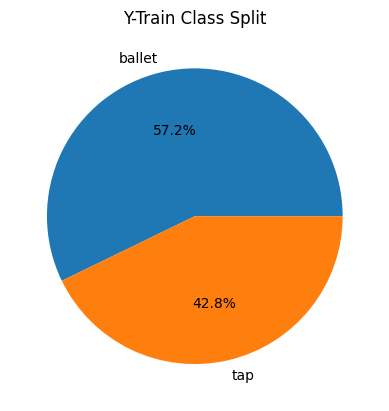

In [20]:
plt.pie(y_train_split[1], labels = y_train_split[0], autopct='%1.1f%%')
plt.title('Y-Train Class Split')
plt.show()

In [21]:
# repeating for validation set

# Initialize lists to store feature data and corresponding labels
val_feature_data = []
val_feature_data_flattened = []

val_labels = []

# Iterate through each json file representing a frame in the training set
for file in X_val_files: 
    for f in file:
        #print('file is: ', file)
        
        #getting body positions for people in frame
        body_positions = get_body_position_info(f)#[0]
        #print(body_positions)
        val_feature_data.append(body_positions)
    
        # Flatten the list of x, y positions
        flattened_positions = [coord for point in body_positions for coord in point]
    
        # Append the flattened positions to the feature data list
        val_feature_data_flattened.append(flattened_positions)
        
        # Determine the label based on the file path (e.g., swing or latin)
        if 'ballet' in f:
            label = 'ballet'
        elif 'tap' in f:
            label = 'tap'
        else:
            label = 'unknown'
        val_labels.append(label)

In [22]:
# Convert the training feature data and labels into numpy arrays
X_val = np.array(val_feature_data)
X_val_flattened = np.array(val_feature_data_flattened)
y_val = np.array(val_labels)

print("Number of frames (rows) in X_val:", len(X_val_flattened))
print("Number of features (columns) in X_val:", len(X_val_flattened[0]))
print("Number of labels in y_val:", len(y_val))

Number of frames (rows) in X_val: 1040
Number of features (columns) in X_val: 17
Number of labels in y_val: 1040


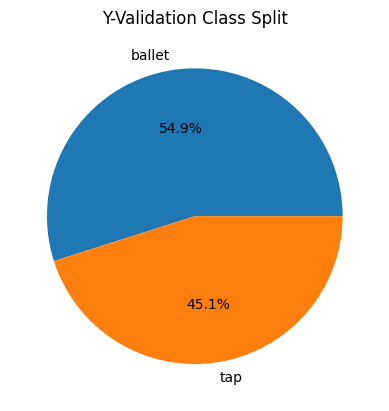

In [23]:
y_val_split = np.unique(y_val, return_counts=True)

plt.pie(y_val_split[1], labels = y_val_split[0], autopct='%1.1f%%')
plt.title('Y-Validation Class Split')
plt.show()

In [24]:
# repeating above steps for test data

# Initialize lists to store feature data and corresponding labels for the testing set
test_feature_data = []
test_labels = []

# Iterate through each JSON file representing a frame in the testing set
for file in X_test_files:
    for f in file:
        # Get body position info for the single person in the frame
        body_positions = get_body_position_info(f)
        
        # Flatten the list of x, y positions
        flattened_positions = [coord for point in body_positions for coord in point]
        
        # Append the flattened positions to the feature data list for the testing set
        test_feature_data.append(flattened_positions)
    
         # Determine the label based on the file path (e.g., ballet or tap)
        if 'ballet' in f:
            label = 'ballet'
        elif 'tap' in f:
            label = 'tap'
        #elif 'latin' in f:
        #    label = 'latin'
        else:
            label = 'unknown'
        test_labels.append(label)

# Convert the testing feature data and labels into numpy arrays
X_test_flattened = np.array(test_feature_data)
y_test = np.array(test_labels)

print("Number of frames (rows) in X_test:", len(X_test_flattened))
print("Number of features (columns) in X_test:", len(X_test_flattened[0]))
print("Number of labels in y_test:", len(y_test))


Number of frames (rows) in X_test: 2995
Number of features (columns) in X_test: 17
Number of labels in y_test: 2995


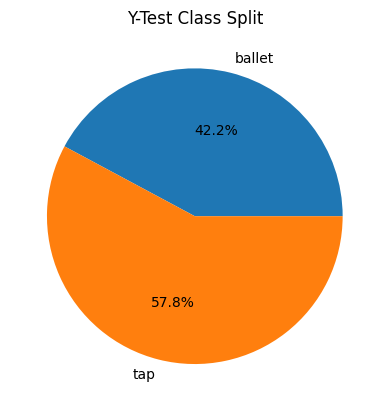

In [25]:
y_test_split = np.unique(y_test, return_counts=True)

plt.pie(y_test_split[1], labels = y_test_split[0], autopct='%1.1f%%')
plt.title('Y-Test Class Split')
plt.show()

## Baseline

In [26]:
total_frames = y_test_split[1] + y_train_split[1] + y_val_split[1]
ballet_percent = round(total_frames[0]/total_frames.sum()*100, 2)
tap_percent = round(total_frames[1]/total_frames.sum()*100, 2)

print('Ballet has', total_frames[0], ' out of ', total_frames.sum(),'frames in the dataset. That is ', ballet_percent, '% of the dataset.')
print('Tap has', total_frames[1], ' out of ', total_frames.sum(),'frames in the dataset. That is ', tap_percent, '% of the dataset.')

Ballet has 8351  out of  15429 frames in the dataset. That is  54.13 % of the dataset.
Tap has 7078  out of  15429 frames in the dataset. That is  45.87 % of the dataset.


When dealing with classification problems, a simple, but useful baseline is to select the majority class (the most common label in the training set) and use it as the prediction for all inputs. Our training dataset consists of 12,349 ballet examples (54%), and 10,536 tap examples (46%). So our majority class baseline classifies everything as ballet. For our particular dataset, this will yield an accuracy of 54%. 

Baseline Class: Ballet

Ballet Accuracy: 54%

## Model Prep

In [26]:
# then train and do the model

# prepping the model 
# Define the body part labels
body_part_labels = [
    "nose_x", "nose_y", 
    "left_eye_x", "left_eye_y", 
    "right_eye_x", "right_eye_y", 
    "left_ear_x", "left_ear_y", 
    "right_ear_x", "right_ear_y", 
    "left_shoulder_x", "left_shoulder_y", 
    "right_shoulder_x", "right_shoulder_y", 
    "left_elbow_x", "left_elbow_y", 
    "right_elbow_x", "right_elbow_y", 
    "left_wrist_x", "left_wrist_y", 
    "right_wrist_x", "right_wrist_y", 
    "left_hip_x", "left_hip_y", 
    "right_hip_x", "right_hip_y", 
    "left_knee_x", "left_knee_y", 
    "right_knee_x", "right_knee_y", 
    "left_ankle_x", "left_ankle_y", 
    "right_ankle_x", "right_ankle_y"
]

# Create a dictionary to map body part labels to column indices
body_part_mapping = {label: i for i, label in enumerate(body_part_labels)}

# Access the x-coordinate of the left eye for all frames
left_eye_x_coordinates = X_train_flattened[:, body_part_mapping["left_eye_x"]]
print(left_eye_x_coordinates)
print(len(left_eye_x_coordinates))

# Access the y-coordinate of the right shoulder for all frames
right_shoulder_y_coordinates = X_train_flattened[:, body_part_mapping["right_shoulder_y"]]
# print(right_shoulder_y_coordinates)
print(len(right_shoulder_y_coordinates))

# Access both x and y coordinates of the nose for all frames
nose_coordinates = X_train_flattened[:, [body_part_mapping["nose_x"], body_part_mapping["nose_y"]]]
# print(nose_coordinates)
print(len(nose_coordinates))

[[1013.27441406  452.57897949]
 [ 991.35424805  459.38430786]
 [ 951.18487549  502.49514771]
 ...
 [ 489.38327026  260.69338989]
 [ 491.11444092  257.32791138]
 [ 490.78302002  253.70779419]]
11394
11394
11394


In [27]:
df_train = pd.DataFrame(X_train.reshape(X_train.shape[0], -1), columns=body_part_labels)
df_train['label'] = y_train
df_train

,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,right_ear_y,...,right_hip_y,left_knee_x,left_knee_y,right_knee_x,right_knee_y,left_ankle_x,left_ankle_y,right_ankle_x,right_ankle_y,label
0,1012.275391,462.577545,1025.262573,452.578979,1013.274414,452.578979,1061.227295,462.577545,1012.275391,466.576965,...,713.541626,1142.147705,823.525818,1007.280273,850.521973,1210.080933,952.507385,1022.265564,1005.499756,ballet
1,993.350952,470.377930,1001.337769,460.383728,991.354248,459.384308,1035.281738,463.381989,1040.273438,464.381409,...,699.244995,1146.098755,823.173035,1014.316345,838.164307,1202.006470,962.092346,998.342712,997.072021,ballet
2,951.184875,512.494019,959.179932,502.495148,951.184875,502.495148,1000.154663,505.494812,959.179932,510.494232,...,737.468323,1140.068237,849.455505,973.171326,853.455017,1198.032471,984.440063,967.175049,994.438904,ballet
3,969.196716,620.896118,980.181335,601.907410,968.198120,603.906189,1021.124084,603.906189,968.198120,605.905029,...,793.793762,1140.956543,872.747009,919.266541,880.742249,1193.882446,987.678894,895.300049,1005.668274,ballet
4,993.960449,569.382507,1008.953491,559.395630,994.959961,557.398315,1047.935425,576.373291,992.960938,569.382507,...,776.109924,1143.890869,871.983521,944.983154,871.983521,1189.869507,986.832092,930.989685,987.830811,ballet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11389,493.485962,278.130829,501.483093,269.132141,486.488434,269.132141,515.478149,271.131836,478.491272,270.131989,...,415.111053,529.473145,496.099365,490.487000,508.097626,540.469238,583.086792,503.482391,614.082336,tap
11390,496.154541,272.824951,505.154114,265.833588,488.154938,264.834839,520.153381,267.831116,480.155334,265.833588,...,423.638672,530.152893,506.536255,492.154755,517.522705,546.152100,599.421509,506.154053,616.400513,tap
11391,496.377319,271.689972,505.369690,261.693085,489.383270,260.693390,522.355286,265.691833,481.390045,264.692139,...,426.642120,528.350159,508.616821,493.379883,526.611267,544.336609,593.590576,506.368835,620.582214,tap
11392,499.107971,266.316650,507.101471,257.327911,491.114441,257.327911,521.090149,261.322906,481.122528,260.324158,...,425.117798,527.085266,514.006470,491.114441,527.988953,542.073120,606.890137,505.103119,605.891418,tap


In [28]:
X_train_flattened_reshaped = X_train_flattened.reshape(X_train_flattened.shape[0], -1)
X_val_flattened_reshaped = X_val_flattened.reshape(X_val_flattened.shape[0], -1)
X_test_flattened_reshaped = X_test_flattened.reshape(X_test_flattened.shape[0], -1)
print(X_train_flattened_reshaped.shape)
print(X_val_flattened_reshaped.shape)
print(X_test_flattened_reshaped.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(11394, 34)
(1040, 34)
(2995, 34)
(11394,)
(1040,)
(2995,)


## Random Forest

In [29]:
X_train_flattened_reshaped = X_train_flattened.reshape(X_train_flattened.shape[0], -1)
X_val_flattened_reshaped = X_val_flattened.reshape(X_val_flattened.shape[0], -1)
X_test_flattened_reshaped = X_test_flattened.reshape(X_test_flattened.shape[0], -1)

# Initialize the Random Forest Classifier
model = RandomForestClassifier(n_estimators= 100, random_state=42, max_depth = 6,  min_samples_leaf = 50) 
# train accuracy: 0.8885378269264526 validation accuracy 0.7990384615384616 test accuracy 0.7809682804674457

# Train the model
model.fit(X_train_flattened_reshaped, y_train)

# prediction on training data
y_pred_train = model.predict(X_train_flattened_reshaped)

# prediction on validation data
y_pred_val = model.predict(X_val_flattened_reshaped)

# Make predictions on the test data
y_pred = model.predict(X_test_flattened_reshaped)

# Evaluate the model
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_val = accuracy_score(y_val, y_pred_val)
accuracy_test = accuracy_score(y_test, y_pred)
print("train accuracy:", accuracy_train, 'validation accuracy', accuracy_val, 'test accuracy', accuracy_test)

train accuracy: 0.8885378269264526 validation accuracy 0.7990384615384616 test accuracy 0.7809682804674457


In [30]:
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
print(model.get_params())

Parameters currently in use:

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 6, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 50, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [31]:
# Source: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74 

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['sqrt'] #['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 100, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 4, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [5, 50]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], 'max_features': ['sqrt'], 'max_depth': [5, 15, 26, 36, 47, 57, 68, 78, 89, 100, None], 'min_samples_split': [2, 4, 10], 'min_samples_leaf': [5, 50], 'bootstrap': [True, False]}


In [33]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=1, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train_flattened_reshaped, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [5, 15, 26, 36, 47, 57, 68,
                                                      78, 89, 100, None],
                                        'max_features': ['sqrt'],
                                        'min_samples_leaf': [5, 50],
                                        'min_samples_split': [2, 4, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000]},
                   random_state=42, verbose=1)

In [34]:
rf_random.best_params_

{'n_estimators': 200,
 'min_samples_split': 10,
 'min_samples_leaf': 50,
 'max_features': 'sqrt',
 'max_depth': 5,
 'bootstrap': True}

In [35]:
base_model = RandomForestClassifier(n_estimators = 10, random_state = 42)

base_model.fit(X_train_flattened_reshaped, y_train)

base_accuracy = evaluate(base_model, X_test_flattened_reshaped, y_test)

best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test_flattened_reshaped, y_test)

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy)))

Model Performance
Test Set Accuracy = 0.76%.
Model Performance
Test Set Accuracy = 0.79%.
Improvement of 3.54%.


In [36]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [100, 150, 200, None],
    'max_features': ['sqrt'],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [200, 500, 1000]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 1)

In [37]:
# Fit the grid search to the data
grid_search.fit(X_train_flattened_reshaped, y_train)
grid_search.best_params_

best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_test_flattened_reshaped, y_test)

print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Model Performance
Test Set Accuracy = 0.77%.
Improvement of 1.19%.


In [38]:
grid_search.best_estimator_

RandomForestClassifier(max_depth=150, min_samples_leaf=5, min_samples_split=8,
                       n_estimators=200)

In [40]:
# Final Model Parameters 

#model = RandomForestClassifier(n_estimators= 150, random_state=42, max_depth = 150, 
#                               min_samples_split = 8, min_samples_leaf = 5, max_features = 'sqrt', bootstrap = True) 
# train accuracy: 0.9965771458662454 validation accuracy 0.7846153846153846 test accuracy 0.7649415692821369

# best model overall (less overfitting that the other two provided by gridsearch params)
model = RandomForestClassifier(n_estimators= 500, random_state=42, max_depth = 5, 
                               min_samples_split = 4, min_samples_leaf = 50, max_features = 'sqrt', bootstrap = True) 
# train accuracy: 0.860628400912761 validation accuracy 0.8048076923076923 test accuracy 0.7919866444073456

# Train the model
model.fit(X_train_flattened_reshaped, y_train)

# prediction on training data
y_pred_train = model.predict(X_train_flattened_reshaped)

# prediction on validation data
y_pred_val = model.predict(X_val_flattened_reshaped)

# Make predictions on the test data
y_pred = model.predict(X_test_flattened_reshaped)

# Evaluate the model
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_val = accuracy_score(y_val, y_pred_val)
accuracy_test = accuracy_score(y_test, y_pred)
print("train accuracy:", accuracy_train, 'validation accuracy', accuracy_val, 'test accuracy', accuracy_test)

train accuracy: 0.860628400912761 validation accuracy 0.8048076923076923 test accuracy 0.7919866444073456


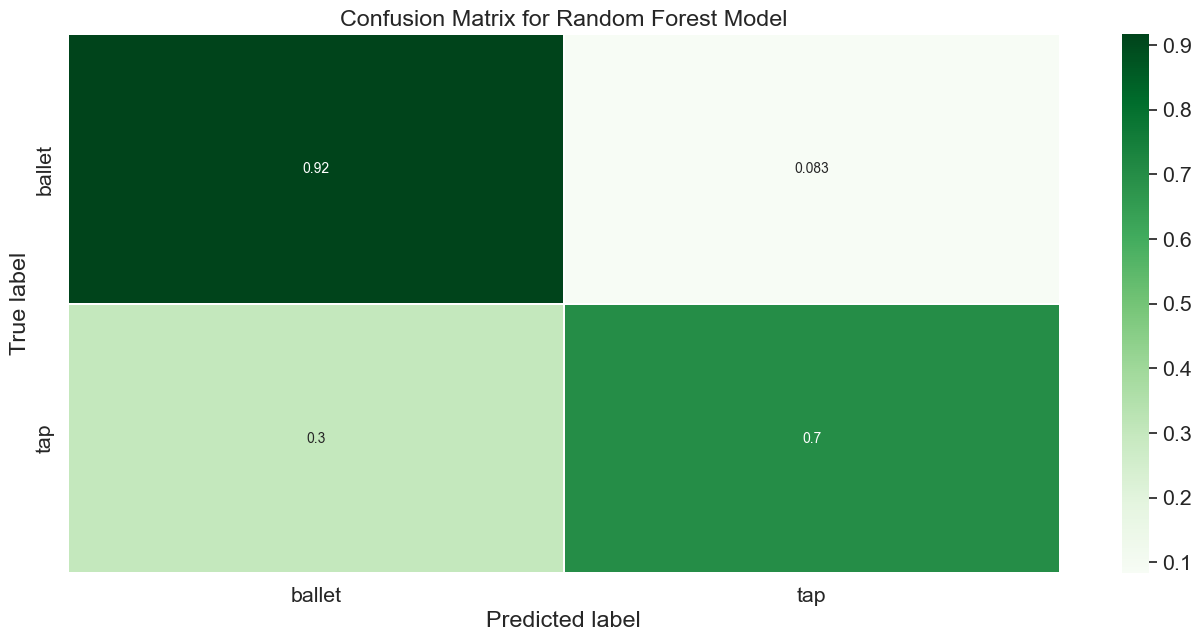

In [41]:
# Get and reshape confusion matrix data
matrix = confusion_matrix(y_test, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['ballet', 'tap']

tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5

plt.xticks(tick_marks2, class_names)
plt.yticks(tick_marks2, class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

In [42]:
# View the classification report for test data and predictions
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      ballet       0.69      0.92      0.79      1263
         tap       0.92      0.70      0.80      1732

    accuracy                           0.79      2995
   macro avg       0.81      0.81      0.79      2995
weighted avg       0.82      0.79      0.79      2995



## Gradient Boost Model

In [43]:
# best model (less work, same results)
model2 = GradientBoostingClassifier(n_estimators=100, max_depth=3, min_samples_leaf = 50)
# train accuracy: 0.860628400912761 validation accuracy: 0.8048076923076923 test accuracy: 0.7919866444073456

#model2 = GradientBoostingClassifier(n_estimators= 200, random_state=42, max_depth = 150, 
#                               min_samples_split = 10, min_samples_leaf = 4)
# train accuracy: 0.860628400912761 validation accuracy: 0.8048076923076923 test accuracy: 0.7919866444073456


# fit the model with the training data
model2.fit(X_train_flattened_reshaped, y_train)

# prediction on training data
y_pred_train2 = model2.predict(X_train_flattened_reshaped)

# prediction on training data
y_pred_val2 = model2.predict(X_val_flattened_reshaped)

# Make predictions on the test data
y_pred2 = model2.predict(X_test_flattened_reshaped)

# Evaluate the model
accuracy_train2 = accuracy_score(y_train, y_pred_train2)
accuracy_val2 = accuracy_score(y_val, y_pred_val2)
accuracy_test2 = accuracy_score(y_test, y_pred2)

print("train accuracy:", accuracy_train, 'validation accuracy:', accuracy_val, 'test accuracy:', accuracy_test)

train accuracy: 0.860628400912761 validation accuracy: 0.8048076923076923 test accuracy: 0.7919866444073456


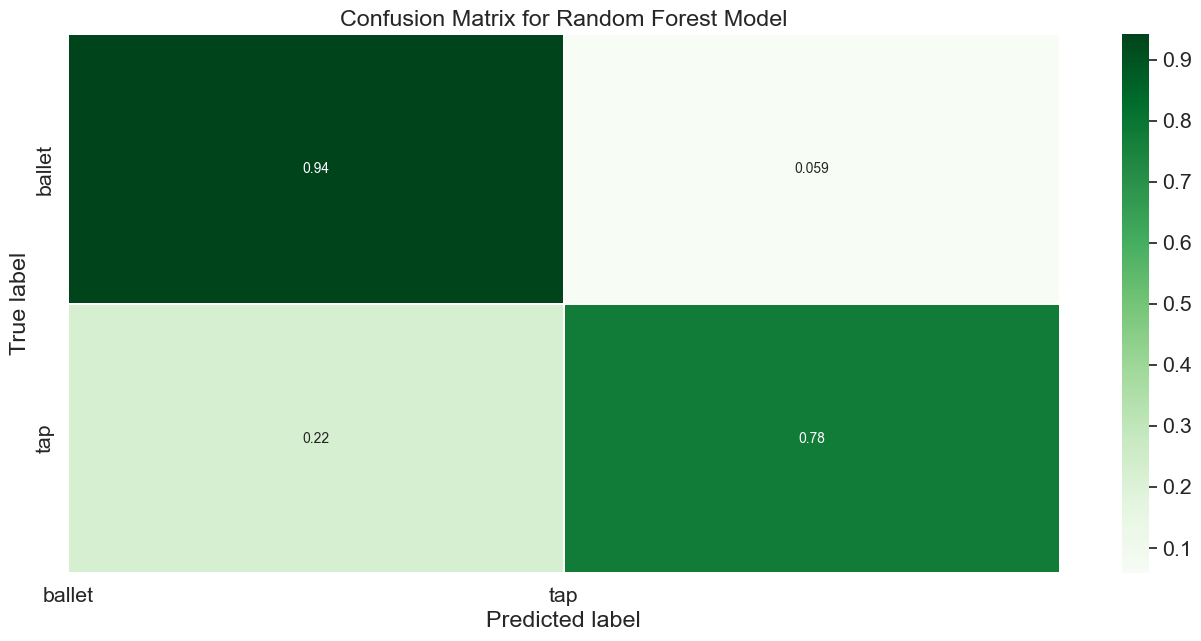

In [44]:
# Get and reshape confusion matrix data
matrix = confusion_matrix(y_test, y_pred2)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['ballet', 'tap']

tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5

plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks2, class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

In [53]:
# View the classification report for test data and predictions
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

      ballet       0.74      0.94      0.83      1263
         tap       0.94      0.76      0.84      1732

    accuracy                           0.84      2995
   macro avg       0.84      0.85      0.84      2995
weighted avg       0.86      0.84      0.84      2995



## Ballet and Tap Model with 2 people (only)

Since each feature is a coordinate value for the body positions of 1 person, including frames with 2 people would mean we are doubling the size of our feature matrix to include the body positions of the second person. Creating a model that includes frames with 1 person and frames with 2 people would create null values in those examples that only have 1 person in a frame; therefore, I will be creating a model that only looks at frames with 2 people (not frames with 1 or 2 people).

In [86]:
# creating a dictionary to hold each video and all of its frames {video_name: [frame1, frame2, etc.]}
videos_ballet = {}
videos_tap = {}

# looping through all dance styles
for d in directories:
    # dict to store avg number of people per video for 1 dance style
    vid_dict = {}
    
    if d == 'ballet':
    
        # looping through each video name
        for p in video_names[d]:
            # list to store num people for each frame for 1 video
            file_list = []
            
            # looping through the files for the corresponding dance style to match the video title
            for f in all_file_names[d]:
                if f.startswith(p):
                    file_path = os.path.join(directory, d, f)
                    ct = person_count(file_path)
                    if ct == 2:
                        file_list.append(file_path)
                    #else:
                    #    file_list.append(np.NaN)
    
            
            vid_dict[p] = file_list
        videos_ballet = vid_dict

    if d == 'tap':
    
        # looping through each video name
        for p in video_names[d]:
            # list to store num people for each frame for 1 video
            file_list = []
            
            # looping through the files for the corresponding dance style to match the video title
            for f in all_file_names[d]:
                if f.startswith(p):
                    file_path = os.path.join(directory, d, f)
                    ct = person_count(file_path)
                    if ct == 2:
                        file_list.append(file_path)
                    #else:
                    #    file_list.append(np.NaN)
    
            
            vid_dict[p] = file_list
        videos_tap = vid_dict


print("Number of selected files for ballet:", len(videos_ballet))
print("Number of selected files for tap:", len(videos_tap))

Number of selected files for ballet: 89
Number of selected files for tap: 95


In [87]:
# making sure no null frames are present
videos_ballet = {k: v for k, v in videos_ballet.items() if len(v) != 0}
videos_tap = {k: v for k, v in videos_tap.items() if len(v) != 0}

print("New Number of selected files for ballet:", len(videos_ballet))
print("New Number of selected files for tap:", len(videos_tap))

New Number of selected files for ballet: 74
New Number of selected files for tap: 47


In [88]:
# SPLIT

X_train_ballet = []
X_test_ballet = []
X_train_tap = []
X_test_tap = []

# append 80% of keys (80% of the key count, but append the contents) to a list of X_train_ballet
split_b = int((len(videos_ballet)*80)/100)
b = 0

# v is the name of the video
# f is the files (with paths) in the video
for v, f in videos_ballet.items():
    if b <= split_b:
        b += 1
        X_train_ballet.append(f)
    else:
        X_test_ballet.append(f)

split_t = int((len(videos_tap)*80)/100)
t = 0

for v, f in videos_tap.items():
    if t <= split_t:
        t += 1
        X_train_tap.append(f)
    else:
        X_test_tap.append(f)

print('Ballet train set length:',len(X_train_ballet))
print('Ballet test set length:',len(X_test_ballet))
print('Tap train set length:',len(X_train_tap))
print('Tap test set length:',len(X_test_tap))

Ballet train set length: 60
Ballet test set length: 14
Tap train set length: 38
Tap test set length: 9


In [89]:
# combine arrays
X_train_files = X_train_ballet + X_train_tap
X_test_files = X_test_ballet + X_test_tap

In [90]:
# Initialize lists to store feature data and corresponding labels
train_feature_data2 = []
train_feature_data_flattened2 = []

train_labels2 = []

# Iterate through each json file representing a frame in the training set
for file in X_train_files: 
    for f in file:
        #print('file is: ', file)
        
        #getting body positions for people in frame
        body_positions = get_body_position_info(f)#[0]
        #print(body_positions)
        
        train_feature_data2.append(body_positions)
    
        # Flatten the list of x, y positions
        flattened_positions = [coord for point in body_positions for coord in point]
    
        # Append the flattened positions to the feature data list
        train_feature_data_flattened2.append(flattened_positions)
        
        # Determine the label based on the file path (e.g., ballet or tap)
        if 'ballet' in f:
            label = 'ballet'
        elif 'tap' in f:
            label = 'tap'
        else:
            label = 'unknown'
        train_labels2.append(label)

In [91]:
#y = [len(i) for i in train_feature_data2]
#y

In [92]:
# Convert the training feature data and labels into numpy arrays
X_train = np.array(train_feature_data2)
X_train_flattened = np.array(train_feature_data_flattened2)
y_train = np.array(train_labels2)

print("Number of frames (rows) in X_train:", len(X_train_flattened))
print("Number of features (columns) in X_train:", len(X_train_flattened[0]))
print("Number of labels in y_train:", len(y_train))

Number of frames (rows) in X_train: 6248
Number of features (columns) in X_train: 34
Number of labels in y_train: 6248


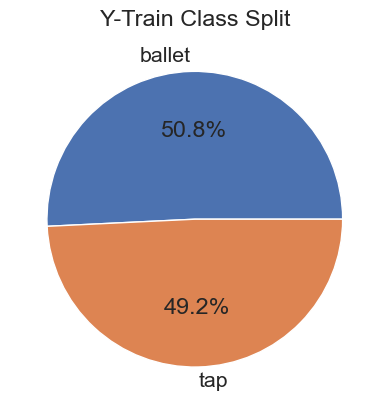

In [93]:
y_train_split = np.unique(y_train, return_counts=True)

plt.pie(y_train_split[1], labels = y_train_split[0], autopct='%1.1f%%')
plt.title('Y-Train Class Split')
plt.show()

In [98]:
# repeating above steps for test data

# Initialize lists to store feature data and corresponding labels for the testing set
test_feature_data = []
test_labels = []

# Iterate through each JSON file representing a frame in the testing set
for file in X_test_files:
    for f in file:
        # Get body position info for the single person in the frame
        body_positions = get_body_position_info(f)
        
        # Flatten the list of x, y positions
        flattened_positions = [coord for point in body_positions for coord in point]
        
        # Append the flattened positions to the feature data list for the testing set
        test_feature_data.append(flattened_positions)
    
         # Determine the label based on the file path (e.g., ballet or tap)
        if 'ballet' in f:
            label = 'ballet'
        elif 'tap' in f:
            label = 'tap'
        else:
            label = 'unknown'
        test_labels.append(label)

# Convert the testing feature data and labels into numpy arrays
X_test_flattened = np.array(test_feature_data)
y_test = np.array(test_labels)

print("Number of frames (rows) in X_test:", len(X_test_flattened))
print("Number of features (columns) in X_test:", len(X_test_flattened[0]))
print("Number of labels in y_test:", len(y_test))


Number of frames (rows) in X_test: 1208
Number of features (columns) in X_test: 34
Number of labels in y_test: 1208


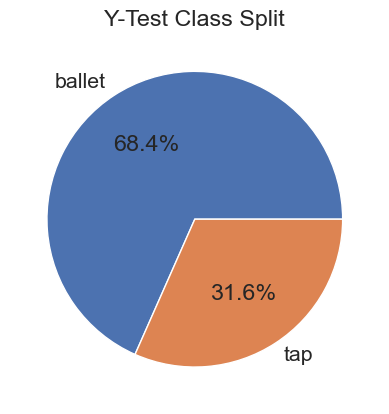

In [95]:
y_test_split = np.unique(y_test, return_counts=True)

plt.pie(y_test_split[1], labels = y_test_split[0], autopct='%1.1f%%')
plt.title('Y-Test Class Split')
plt.show()

In [109]:
# then train and do the model

# prepping the model 
# Define the body part labels
body_part_labels = [
    "nose_x_p0", "nose_y_p0", 
    "left_eye_x_p0", "left_eye_y_p0", 
    "right_eye_x_p0", "right_eye_y_p0", 
    "left_ear_x_p0", "left_ear_y_p0", 
    "right_ear_x_p0", "right_ear_y_p0", 
    "left_shoulder_x_p0", "left_shoulder_y_p0", 
    "right_shoulder_x_p0", "right_shoulder_y_p0", 
    "left_elbow_x_p0", "left_elbow_y_p0", 
    "right_elbow_x_p0", "right_elbow_y_p0", 
    "left_wrist_x_p0", "left_wrist_y_p0", 
    "right_wrist_x_p0", "right_wrist_y_p0", 
    "left_hip_x_p0", "left_hip_y_p0", 
    "right_hip_x_p0", "right_hip_y_p0", 
    "left_knee_x_p0", "left_knee_y_p0", 
    "right_knee_x_p0", "right_knee_y_p0", 
    "left_ankle_x_p0", "left_ankle_y_p0", 
    "right_ankle_x_p0", "right_ankle_y_p0",
    "nose_x_p1", "nose_y_p1", 
    "left_eye_x_p1", "left_eye_y_p1", 
    "right_eye_x_p1", "right_eye_y_p1", 
    "left_ear_x_p1", "left_ear_y_p1", 
    "right_ear_x_p1", "right_ear_y_p1", 
    "left_shoulder_x_p1", "left_shoulder_y_p1", 
    "right_shoulder_x_p1", "right_shoulder_y_p1", 
    "left_elbow_x_p1", "left_elbow_y_p1", 
    "right_elbow_x_p1", "right_elbow_y_p1", 
    "left_wrist_x_p1", "left_wrist_y_p1", 
    "right_wrist_x_p1", "right_wrist_y_p1", 
    "left_hip_x_p1", "left_hip_y_p1", 
    "right_hip_x_p1", "right_hip_y_p1", 
    "left_knee_x_p1", "left_knee_y_p1", 
    "right_knee_x_p1", "right_knee_y_p1", 
    "left_ankle_x_p1", "left_ankle_y_p1", 
    "right_ankle_x_p1", "right_ankle_y_p1"
]

# Create a dictionary to map body part labels to column indices
body_part_mapping = {label: i for i, label in enumerate(body_part_labels)}

# Access the x-coordinate of the left eye for all frames
left_eye_x_coordinates = X_train_flattened[:, body_part_mapping["left_eye_x_p0"]]
print(left_eye_x_coordinates)
print(len(left_eye_x_coordinates))

# Access the y-coordinate of the right shoulder for all frames
right_shoulder_y_coordinates = X_train_flattened[:, body_part_mapping["right_shoulder_y_p0"]]
# print(right_shoulder_y_coordinates)
print(len(right_shoulder_y_coordinates))

# Access both x and y coordinates of the nose for all frames
nose_coordinates = X_train_flattened[:, [body_part_mapping["nose_x_p0"], body_part_mapping["nose_y_p0"]]]
# print(nose_coordinates)
print(len(nose_coordinates))


[[455.59283447 560.20910645]
 [454.18060303 560.96728516]
 [455.88616943 560.56115723]
 ...
 [584.49456787 194.1678009 ]
 [588.01641846 193.09588623]
 [591.65338135 197.41473389]]
6248
6248
6248


In [107]:
X_train.reshape(X_train.shape[0], -1)

array([[ 456.59060669,  570.19696045,  465.57037354, ..., 1029.12060547,
         939.77954102,  994.14971924],
       [ 455.18008423,  570.9553833 ,  466.17456055, ..., 1022.16033936,
         943.00030518,  989.1618042 ],
       [ 455.88616943,  570.54504395,  463.88049316, ..., 1027.61132812,
         942.2388916 ,  987.6237793 ],
       ...,
       [ 601.4821167 ,  210.15383911,  618.46966553, ...,  871.36669922,
         797.03295898,  858.38220215],
       [ 602.98974609,  217.07073975,  617.96307373, ...,  873.74572754,
         790.46887207,  861.74865723],
       [ 604.64447021,  215.39477539,  622.63214111, ...,  873.30065918,
         793.23443604,  862.3067627 ]])

In [110]:
df_train = pd.DataFrame(X_train.reshape(X_train.shape[0], -1), columns=body_part_labels)
df_train['label'] = y_train
df_train

,nose_x_p0,nose_y_p0,left_eye_x_p0,left_eye_y_p0,right_eye_x_p0,right_eye_y_p0,left_ear_x_p0,left_ear_y_p0,right_ear_x_p0,right_ear_y_p0,...,right_hip_y_p1,left_knee_x_p1,left_knee_y_p1,right_knee_x_p1,right_knee_y_p1,left_ankle_x_p1,left_ankle_y_p1,right_ankle_x_p1,right_ankle_y_p1,label
0,456.590607,570.196960,465.570374,558.211548,455.592834,560.209106,497.498474,560.209106,503.484985,559.210327,...,757.346741,991.733459,904.224548,910.805176,888.237854,1015.712219,1029.120605,939.779541,994.149719,ballet
1,455.180084,570.955383,466.174561,558.969604,454.180603,560.967285,499.157990,559.968445,499.157990,557.970825,...,756.172180,991.815063,907.165466,910.125061,887.166382,1015.724365,1022.160339,943.000305,989.161804,ballet
2,455.886169,570.545044,463.880493,558.564392,455.886169,560.561157,499.854950,559.562744,500.854218,558.564392,...,751.697021,990.054993,903.649841,911.357666,887.654846,1014.959167,1027.611328,942.238892,987.623779,ballet
3,449.543518,569.732727,457.535065,558.748230,449.543518,557.749634,488.502350,566.736938,490.500244,567.735535,...,763.550964,983.535034,896.393127,887.781006,886.405029,1003.483826,1016.250793,887.781006,1010.257874,ballet
4,441.929413,570.000549,452.928070,560.007385,441.929413,560.007385,487.923798,564.004639,490.923431,563.005310,...,759.183044,986.522034,903.985840,876.541504,889.006287,1005.518616,1017.830811,843.547363,1016.832153,ballet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6243,600.974121,208.123917,617.947083,194.124939,585.998047,192.125076,635.918457,187.125443,552.052124,175.126312,...,533.384583,983.234497,719.351135,827.415771,666.360657,968.251953,871.323853,805.441284,846.328369,tap
6244,601.075378,208.908646,617.074585,193.922073,586.076172,191.923859,635.073669,187.927444,552.077881,175.938187,...,534.211304,983.991211,719.023376,827.120239,667.076233,968.004395,871.867981,806.137512,844.895386,tap
6245,601.482117,210.153839,618.469666,195.166931,584.494568,194.167801,635.457214,190.171295,554.516541,177.182648,...,538.762573,986.700623,715.552185,829.975281,681.592590,966.735596,871.366699,797.032959,858.382202,tap
6246,602.989746,217.070740,617.963074,200.088547,588.016418,193.095886,635.931030,191.097977,558.069824,186.103210,...,542.826477,985.416077,717.783752,835.456665,696.788879,967.420898,873.745728,790.468872,861.748657,tap


In [111]:
X_train_flattened_reshaped = X_train_flattened.reshape(X_train_flattened.shape[0], -1)
X_test_flattened_reshaped = X_test_flattened.reshape(X_test_flattened.shape[0], -1)
print(X_train_flattened_reshaped.shape)
print(X_test_flattened_reshaped.shape)
print(y_train.shape)
print(y_test.shape)

(6248, 68)
(1208, 68)
(6248,)
(1208,)


In [115]:
X_train_flattened_reshaped = X_train_flattened.reshape(X_train_flattened.shape[0], -1)
X_test_flattened_reshaped = X_test_flattened.reshape(X_test_flattened.shape[0], -1)

# Initialize the Random Forest Classifier
model = RandomForestClassifier(n_estimators= 100, random_state=42, max_depth = 6,  min_samples_leaf = 50)
# train accuracy: 0.9471830985915493 test accuracy 0.6829470198675497

# Train the model
model.fit(X_train_flattened_reshaped, y_train)

# prediction on training data
y_pred_train = model.predict(X_train_flattened_reshaped)

# Make predictions on the test data
y_pred = model.predict(X_test_flattened_reshaped)

# Evaluate the model
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred)
print("train accuracy:", accuracy_train, 'test accuracy', accuracy_test)

train accuracy: 0.9471830985915493 test accuracy 0.6829470198675497


In [ ]:
# Get and reshape confusion matrix data
matrix = confusion_matrix(y_test, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['ballet', 'tap']

tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5

plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks2, class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

In [ ]:
# View the classification report for test data and predictions
print(classification_report(y_test, y_pred))

In [116]:
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
print(model.get_params())

Parameters currently in use:

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 6, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 50, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [120]:
# narrow down parameters using RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 100, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 4, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [5, 10, 50]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], 'max_features': ['sqrt'], 'max_depth': [5, 15, 26, 36, 47, 57, 68, 78, 89, 100, None], 'min_samples_split': [2, 4, 10], 'min_samples_leaf': [5, 10, 50], 'bootstrap': [True, False]}


In [121]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train_flattened_reshaped, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [5, 15, 26, 36, 47, 57, 68,
                                                      78, 89, 100, None],
                                        'max_features': ['sqrt'],
                                        'min_samples_leaf': [5, 10, 50],
                                        'min_samples_split': [2, 4, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000]},
                   random_state=42, verbose=2)

In [122]:
rf_random.best_params_

{'n_estimators': 100,
 'min_samples_split': 4,
 'min_samples_leaf': 50,
 'max_features': 'sqrt',
 'max_depth': 68,
 'bootstrap': True}

In [126]:
# checking model improvement 
base_model = RandomForestClassifier(n_estimators = 10, random_state = 42)

base_model.fit(X_train_flattened_reshaped, y_train)

base_accuracy = evaluate(base_model, X_test_flattened_reshaped, y_test)

best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test_flattened_reshaped, y_test)

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy))

Model Performance
Test Set Accuracy = 0.79%.
Model Performance
Test Set Accuracy = 0.70%.
Improvement of -11.60%.


In [145]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [70, 80, 90, None],
    'max_features': ['sqrt'],
    'min_samples_leaf': [40, 50, 60],
    'min_samples_split': [2, 3, 4],
    'n_estimators': [75, 100, 150]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 7, n_jobs = -1, verbose = 2)

In [146]:
# Fit the grid search to the data
grid_search.fit(X_train_flattened_reshaped, y_train)
grid_search.best_params_

best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_test_flattened_reshaped, y_test)

print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy))

Fitting 7 folds for each of 108 candidates, totalling 756 fits
[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=50, min_samples_split=3, n_estimators=100; total time=   1.9s
[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=50, min_samples_split=3, n_estimators=200; total time=   3.2s
[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=50, min_samples_split=3, n_estimators=300; total time=   4.9s
[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=50, min_samples_split=4, n_estimators=100; total time=   1.7s
[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=50, min_samples_split=4, n_estimators=300; total time=   5.1s
[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=50, min_samples_split=8, n_estimators=100; total time=   1.6s
[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=50, min_samples_split=8, n_estimators=10

In [147]:
grid_search.best_estimator_

RandomForestClassifier(max_depth=80, min_samples_leaf=60, min_samples_split=3)

In [166]:
# Final Model Parameters 
#model = RandomForestClassifier(n_estimators= 100, random_state=42, max_depth =  80,
#                               min_samples_split = 3, min_samples_leaf = 50, max_features = 'sqrt', bootstrap = True) 
# train accuracy: 0.9510243277848912 test accuracy 0.734271523178808

#model = RandomForestClassifier(n_estimators= 100, random_state=42, max_depth =  10,
#                               min_samples_split = 3, min_samples_leaf = 20, max_features = 'sqrt', bootstrap = True)
# train accuracy: 0.9713508322663252 test accuracy 0.7624172185430463

#model = RandomForestClassifier(n_estimators= 100, random_state=42, max_depth =  10,
#                               min_samples_split = 3, min_samples_leaf = 18, max_features = 'sqrt', bootstrap = True)
# train accuracy: 0.9731113956466069 test accuracy 0.7665562913907285

model = RandomForestClassifier(random_state=42)
# train accuracy: 1.0 test accuracy 0.7839403973509934

# Train the model
model.fit(X_train_flattened_reshaped, y_train)

# prediction on training data
y_pred_train = model.predict(X_train_flattened_reshaped)

# Make predictions on the test data
y_pred = model.predict(X_test_flattened_reshaped)

# Evaluate the model
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred)
print("train accuracy:", accuracy_train, 'test accuracy', accuracy_test)

train accuracy: 1.0 test accuracy 0.7839403973509934


This the model may not be complex enough or may not have enough data, both of which could cause the overfitting we see above.